In [1]:
from egg.zoo.simclr.games import build_game
import json
import argparse
import torch

In [2]:
params = \
"""
{
    "similarity": "cosine",
    "loss_temperature": 1.0,
    "model_name": "resnet50",
    "pretrain_vision": true,
    "n_epoch": 100,
    "batch_size": 32,
    "lr": 2.4,
    "random_seed": 111,
    "fp16": true,
    "shared_vision": true,
    "use_augmentations": true,
    "use_ntxent": true,
    "wandb": false,
    "gs_temperature": 5.0,
    "gs_temperature_decay": 1.0,
    "minimum_gs_temperature": 1.0,
    "update_gs_temp_frequency": 1,
    "validation_dataset_dir": "/datasets01/imagenet_full_size/061417/val",
    "validation_freq": 5
}
"""
params = json.loads(params)


distributed_context = argparse.Namespace(is_distributed=False)

other_params = dict(batch_size=128, checkpoint_freq=1, 
                dataset_dir='/datasets01/imagenet_full_size/061417/train', 
                dataset_name='imagenet', device=torch.device(type='cuda'),
                distributed_context=distributed_context, 
                fp16=True, gs_temperature=5.0, gs_temperature_decay=1.0, image_size=224, 
                load_from_checkpoint=None, loss_temperature=0.1, lr=2.4, max_len=1, 
                minimum_gs_temperature=1.0, model_name='resnet50', n_epochs=100,
                no_cuda=False, num_workers=4, optimizer='adam', pdb=False, preemptable=True,
                pretrain_vision=False, projection_hidden_dim=2048, projection_output_dim=2048,
                random_seed=111, shared_vision=True, similarity='cosine', straight_through=False,
                tensorboard=False, tensorboard_dir='runs/', train_gs_temperature=False, update_freq=1,
                update_gs_temp_frequency=1, use_augmentations=True, use_ntxent=True,
                validation_dataset_dir='/datasets01/imagenet_full_size/061417/val',
                validation_freq=5, vocab_size=10, wandb=True, weight_decay=1e-05)

params.update(other_params)

params = argparse.Namespace(**params)

In [3]:
game = build_game(params)

In [4]:
#checkpoint = torch.load("/private/home/rdessi/last_exp/fixed_temp_shared_vision_bn/38157309_0/final.tar")
checkpoint = torch.load("/private/home/rdessi/last_exp/fixed_temp_w_decay_shared_vision_bn/38157310_0/final.tar")

In [5]:
game.load_state_dict(checkpoint.model_state_dict)

<All keys matched successfully>

In [6]:
game

VisionGameWrapper(
  (game): SymbolGameGS(
    (sender): Sender(
      (fwd): Sequential(
        (0): Linear(in_features=2048, out_features=2048, bias=True)
        (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (gs_layer): GumbelSoftmaxLayer()
      (fc): Linear(in_features=2048, out_features=2048, bias=False)
    )
    (receiver): Receiver(
      (fwd): Sequential(
        (0): Linear(in_features=2048, out_features=2048, bias=True)
        (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=2048, out_features=2048, bias=False)
      )
    )
  )
  (vision_module): VisionModule(
    (encoder): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kern

In [7]:
from egg.zoo.simclr.data import get_dataloader

opts = params

train_loader, validation_loader = get_dataloader(
        dataset_name=opts.dataset_name,
        dataset_dir=opts.dataset_dir,
        image_size=opts.image_size,
        batch_size=opts.batch_size,
        validation_dataset_dir=opts.validation_dataset_dir,
        num_workers=opts.num_workers,
        use_augmentations=opts.use_augmentations,
        imagenet_normalization=opts.dataset_name.lower() == "imagenet" or opts.pretrain_vision,
        is_distributed=opts.distributed_context.is_distributed,
        seed=opts.random_seed
    )

In [208]:
game = game.cuda().eval()
token_histogram = []

In [209]:
for (x_i, x_j), labels in train_loader:
    x_i = x_i.cuda()
    x_j = x_j.cuda()
    
    with torch.no_grad():
        sender_encoded_input, receiver_encoded_input = game.vision_module(x_i, x_j)
        *rest, pre_gs = game.game.sender(sender_encoded_input)
        
        tokens = pre_gs.argmax(dim=-1).cpu().tolist()
        token_histogram.extend(tokens)
        
    if len(token_histogram) > 50_000: break

In [210]:
len(token_histogram)

50048

In [218]:
histogram = {}
for token in token_histogram:
    histogram[token] = 1 + histogram.get(token, 0)

In [219]:
histogram = [(token, frq) for token, frq in histogram.items()]

In [220]:
histogram.sort(key=lambda x: x[1], reverse=True)

In [221]:
histogram

[(1755, 109),
 (1099, 105),
 (551, 103),
 (1545, 101),
 (1254, 98),
 (1049, 96),
 (794, 96),
 (1132, 94),
 (1278, 94),
 (885, 93),
 (1569, 92),
 (580, 92),
 (755, 91),
 (1817, 91),
 (1362, 91),
 (1867, 88),
 (1326, 88),
 (935, 87),
 (21, 87),
 (62, 86),
 (174, 85),
 (1244, 85),
 (1463, 85),
 (1580, 85),
 (1831, 85),
 (1643, 84),
 (847, 84),
 (1329, 84),
 (251, 83),
 (1562, 83),
 (739, 83),
 (156, 83),
 (36, 82),
 (1557, 82),
 (1119, 82),
 (638, 81),
 (169, 81),
 (1263, 81),
 (1600, 81),
 (1734, 81),
 (1372, 81),
 (653, 80),
 (1693, 80),
 (23, 80),
 (397, 80),
 (1462, 80),
 (1790, 79),
 (1820, 79),
 (1513, 79),
 (1981, 79),
 (681, 79),
 (1637, 79),
 (368, 78),
 (1227, 78),
 (361, 78),
 (687, 78),
 (1921, 78),
 (41, 78),
 (1012, 78),
 (1524, 78),
 (86, 77),
 (1385, 77),
 (1764, 77),
 (267, 77),
 (1440, 77),
 (145, 77),
 (230, 77),
 (327, 77),
 (83, 77),
 (40, 77),
 (894, 77),
 (1962, 77),
 (965, 76),
 (1910, 76),
 (774, 76),
 (260, 76),
 (51, 76),
 (1298, 76),
 (385, 76),
 (778, 75),
 (8

In [222]:
for p in game.parameters():
    p.requires_grad_(False)
    
game.game.sender.gs_layer.train()

GumbelSoftmaxLayer()

In [311]:
random_image = x_i[4, ...].clone()
random_image.uniform_().div_(100).unsqueeze_(0)
random_image.requires_grad_(True)
pass

In [312]:
#im = random_image.detach().squeeze().cpu().numpy()
#plt.imshow(im)

In [313]:
optimizer = torch.optim.SGD((random_image, ), lr=0.1)

In [314]:
for i in range(1000):
    optimizer.zero_grad()
    sender_encoded_input, _ = game.vision_module(random_image, random_image)
    *rest, message, pre_gs = game.game.sender(sender_encoded_input)
    
    loss = -pre_gs[0, 21]#(-2 * pre_gs[0, 1755] + pre_gs.sum())
    
    loss.backward()
    
    optimizer.step()
    if i > 0 and i % 100 == 0:
        print(loss.detach().item())

-74.90629577636719
-93.55198669433594
-99.79029083251953
-103.88658905029297
-105.45712280273438
-109.48168182373047
-111.01911926269531
-113.01122283935547
-114.2713394165039


In [315]:
loss.detach(), random_image

(tensor(-115.4283, device='cuda:0'),
 tensor([[[[-0.3043,  0.0983, -0.2040,  ..., -0.0463,  0.0905,  0.0137],
           [ 0.0675,  0.0259,  0.1597,  ..., -0.0183,  0.0170,  0.0452],
           [ 0.0240,  0.0450, -0.1327,  ...,  0.0878,  0.0729,  0.1287],
           ...,
           [-0.0753, -0.0545, -0.0180,  ...,  0.1951,  0.1743,  0.2245],
           [-0.0538,  0.0192, -0.0174,  ...,  0.1528,  0.0829,  0.2331],
           [ 0.0211,  0.0768,  0.3003,  ...,  0.1378,  0.1014,  0.2236]],
 
          [[ 0.0660,  0.1518, -0.3818,  ...,  0.0231,  0.1802,  0.0511],
           [-0.0032,  0.0118,  0.0292,  ...,  0.0801,  0.1032,  0.0650],
           [ 0.0830,  0.1705, -0.4160,  ...,  0.0959,  0.0581,  0.1068],
           ...,
           [-0.0279, -0.0429, -0.0064,  ...,  0.1874,  0.0429,  0.0232],
           [-0.0682, -0.0563, -0.0228,  ...,  0.1415, -0.0528,  0.0406],
           [ 0.1385,  0.0987,  0.3331,  ...,  0.1527,  0.0185,  0.0538]],
 
          [[-0.2278, -0.2048, -0.2564,  ..., -0.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


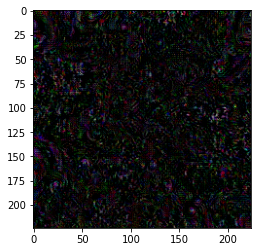

In [316]:
import matplotlib.pyplot as plt

im = random_image.detach().squeeze().cpu().transpose(2, 0).numpy()
#im -= im.mean()
#im /= im.std()

plt.imshow(im)